# Load raw data

In [1]:
import pandas as pd

file_name = 'train1'
df = pd.read_csv(f'../data/raw/{file_name}.csv')
print(df.head())

                                            promoter  mrna_level
0  ATTCCTTGCAGTGTTTTGAATGAAGAAGAGGGAAAAGCTCTTTTAG...    5.052171
1  GTTTATGTAATGTACACCGTCTTGATCGCTTTCATCATCATCTCGA...    5.038447
2  TACGTTGTTTCTCCACCCTCACAGATATTTTTGGAGACACCACATG...    6.809381
3  TTGGTTCATGGTTAAACTGATTACTATTTCATCGACAAAATAGCTC...    3.485762
4  AACGTCCGTACCATAAATACAGACTGCAGTGTGGTGTTCGAAGAAG...    5.460114


# Set up suffix array for ChimeraARS

In [2]:
from chimera import calc_cARS, build_suffix_array

# setup chimeraARS index using all genes
suffix_array = build_suffix_array(df['promoter'])

# setup chimeraARS index using only top 15% most highly expressed genes
n = int(0.15 * len(df))
highly_expressed_genes = df.nlargest(n, 'mrna_level')
highly_expressed_genes.reset_index(inplace=True)
highly_expressed_suffix_array = build_suffix_array(highly_expressed_genes['promoter'])

# Compute ChimeraARS score

In [3]:
# define parameters
max_len = 120
max_pos = 0.5

# Chimera ARS (cARS) with respect to all genes
df[f'chimeraARS'] = calc_cARS(df['promoter'], suffix_array, max_len=max_len, max_pos=max_pos)

# Chimera ARS (cARS) with respect to highly expressed genes
df[f'highly_expressed_chimeraARS'] = calc_cARS(df['promoter'], highly_expressed_suffix_array, max_len=max_len, max_pos=max_pos)

# Calculate Position Specific ChimeraARS score

In [4]:
# define parameters
win_params = {'size': 150, 'center': 0, 'by_start': True, 'by_stop': True}

# Position-Specific Chimera ARS (PScARS) with respect to all genes
df[f'PS_chimeraARS'] = calc_cARS(df['promoter'], suffix_array, win_params=win_params, max_len=max_len, max_pos=max_pos)

# Position-Specific Chimera ARS (PScARS) with respect to highly expressed genes
df[f'highly_expressed_PS_chimeraARS'] = calc_cARS(df['promoter'], highly_expressed_suffix_array, win_params=win_params, max_len=max_len, max_pos=max_pos)

# Compute ChimeraARS score for some windows

In [ ]:
# win_size = 100
# step = 50
# last_start = len(df.loc[0, 'promoter']) - win_size
# sliding_windows = [[start, start + win_size] for start in range(0, last_start+1, step)]
distal_proximal_core_windows = [[0,500],[500,800],[800,1000]]

for (start,end) in distal_proximal_core_windows:
    window = df['promoter'].str[start:end]
    suffix_array = build_suffix_array(window)
    df[f'chimeraARS_{start}_{end}'] = calc_cARS(window, suffix_array, max_len=max_len, max_pos=max_pos)
    df[f'highly_expressed_chimeraARS_{start}_{end}'] = calc_cARS(window, highly_expressed_suffix_array, max_len=max_len, max_pos=max_pos)
    
    # Print progress since this takes a while
    print(f"Completed window from {start} to {end}.")


# Plot results

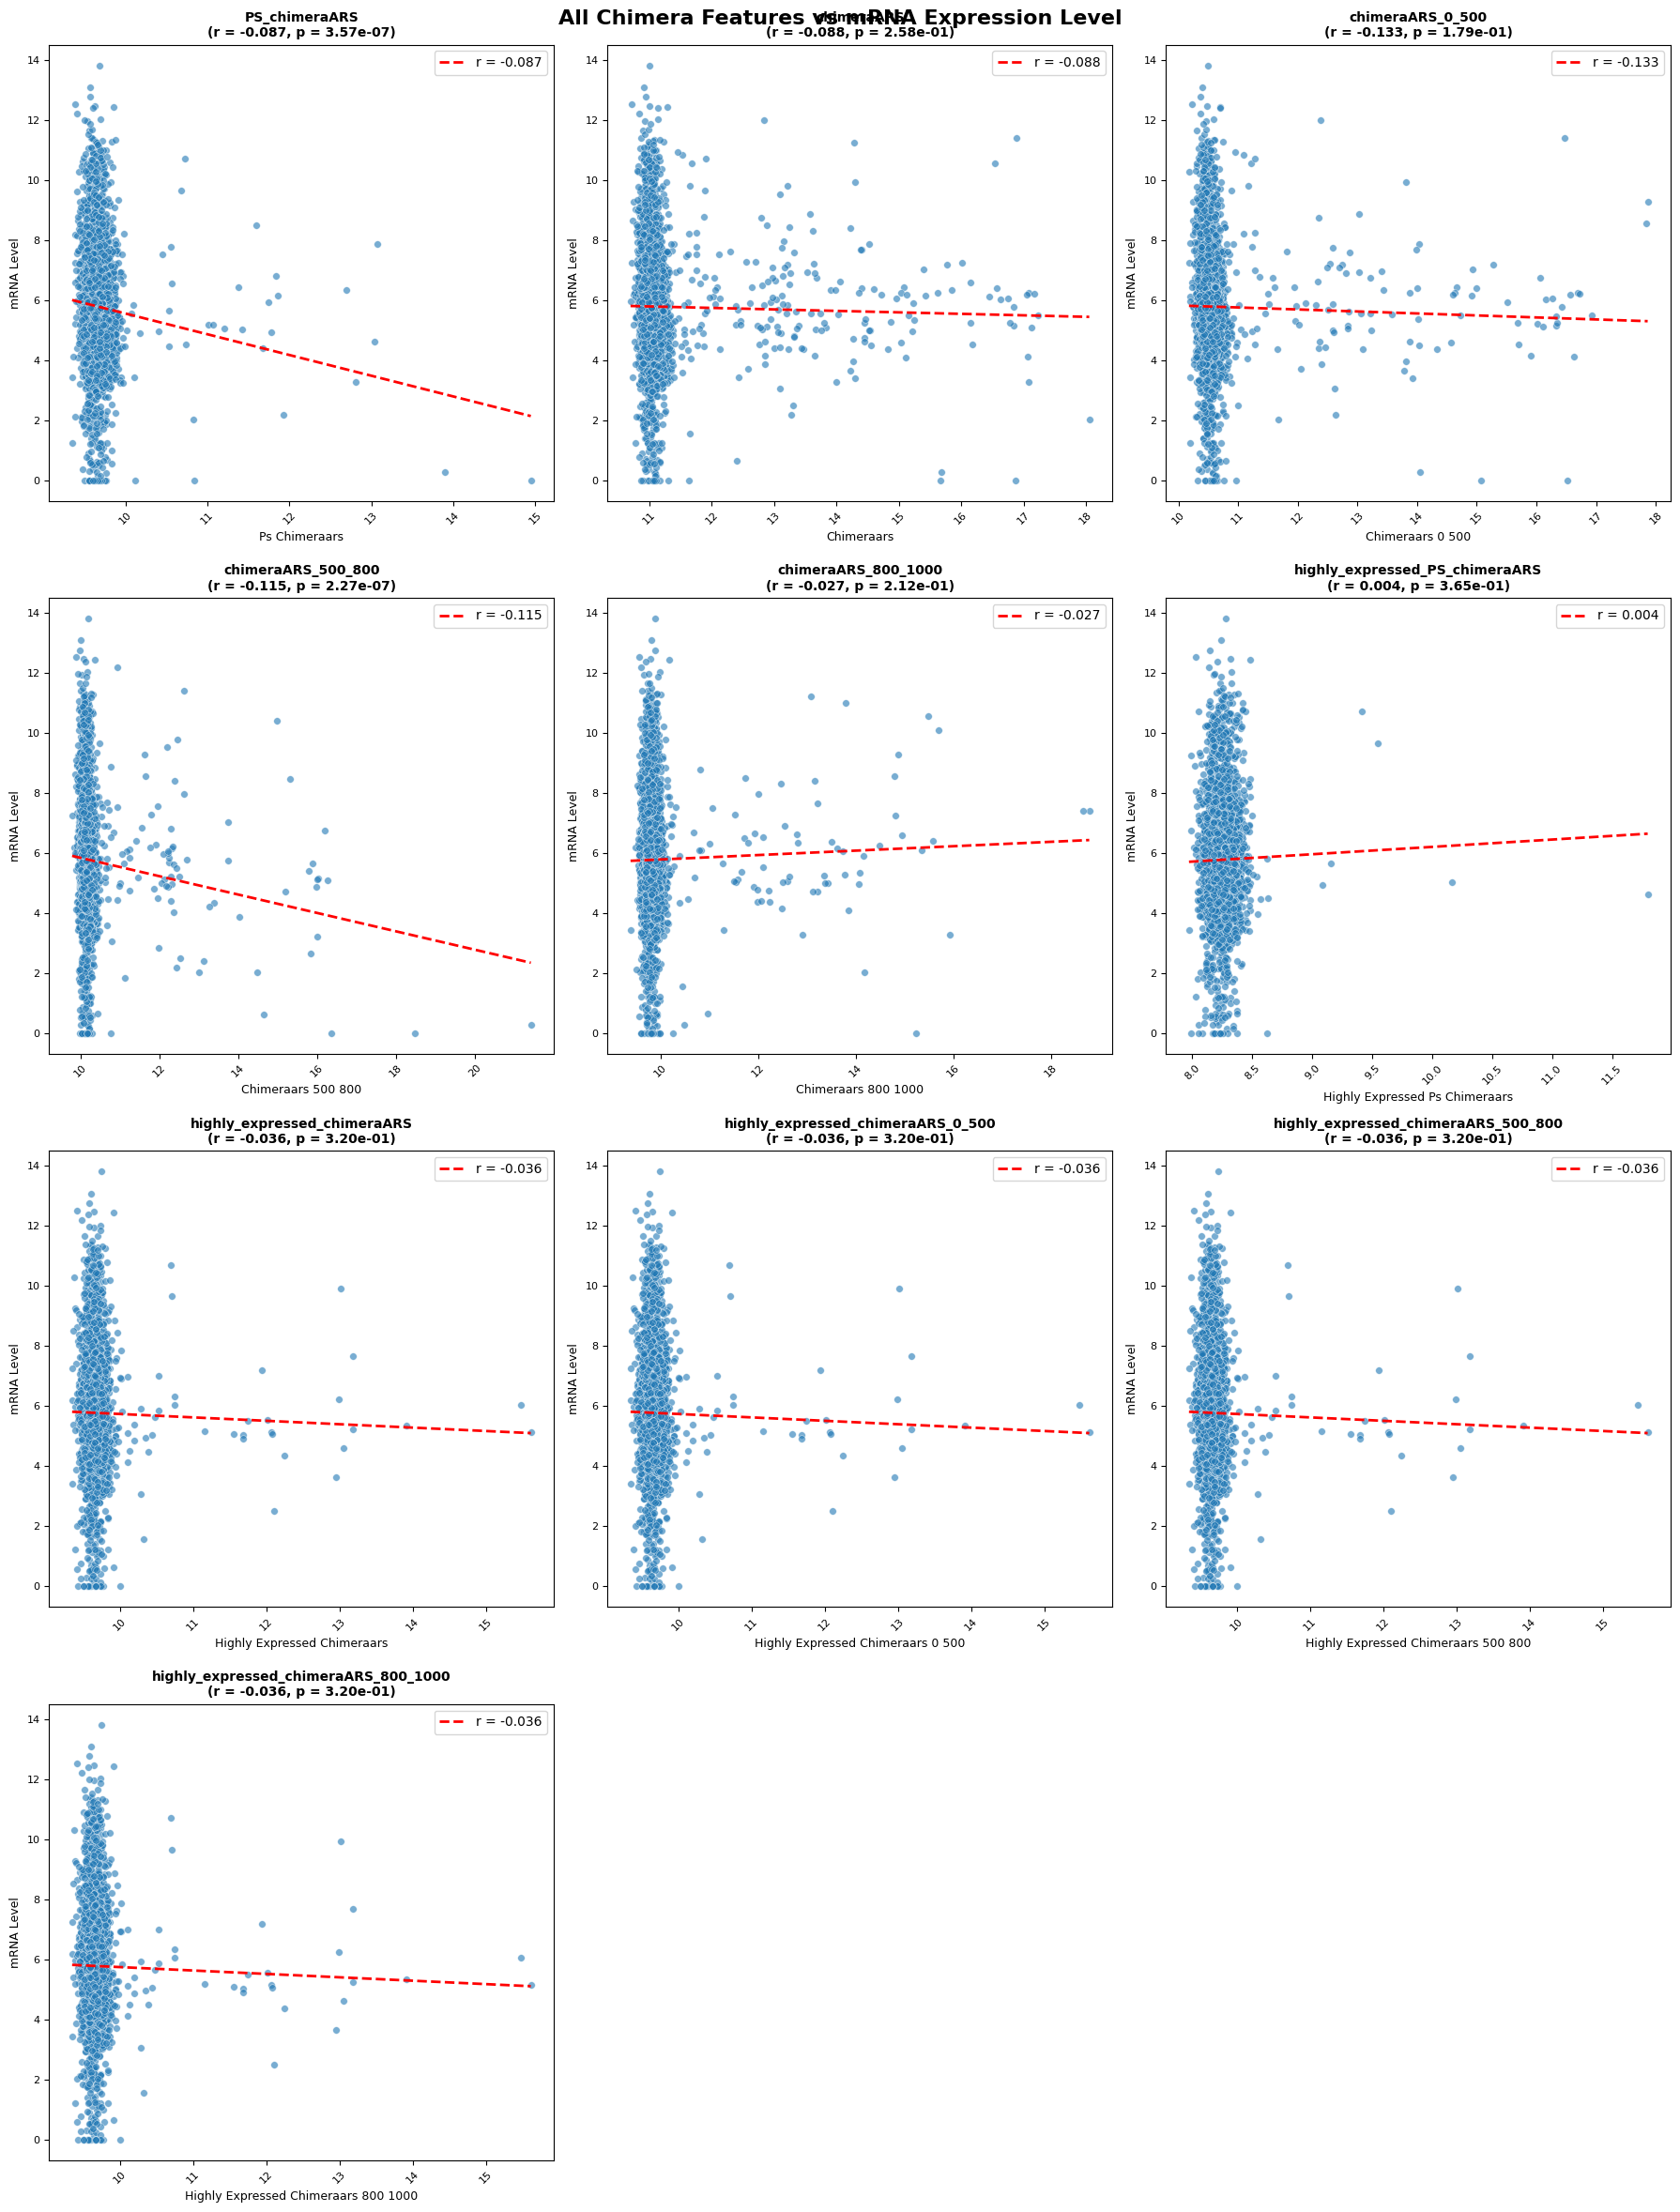

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

feature_cols = df.columns.difference(['promoter', 'mrna_level']).to_list()

# Determine subplot layout: 3 columns, calculate rows based on number of features
cols = 3
rows = (len(feature_cols) + cols - 1) // cols  # Ceiling division
fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows))  # Adjust figsize based on rows
axes = axes.flatten()

for i, feature in enumerate(feature_cols):
    ax = axes[i]
    corr, p_value = spearmanr(df[feature], df['mrna_level'])

    # Create scatter plot
    sns.scatterplot(data=df, x=feature, y='mrna_level', ax=ax, alpha=0.6, s=30)

    # Add correlation line (optional - linear regression)
    try:
        from scipy.stats import linregress
        slope, intercept, r_value, p_value, std_err = linregress(df[feature], df['mrna_level'])
        x_range = [df[feature].min(), df[feature].max()]
        y_range = [slope * x + intercept for x in x_range]
        ax.plot(x_range, y_range, color='red', linestyle='--', linewidth=2,
                label=f'r = {corr:.3f}')
        ax.legend()
    except:
        pass

    # Set titles and labels
    ax.set_title(f'{feature}\n(r = {corr:.3f}, p = {p_value:.2e})',
                fontsize=10, fontweight='bold')
    ax.set_xlabel(feature.replace('_', ' ').title(), fontsize=9)
    ax.set_ylabel('mRNA Level', fontsize=9)

    # Rotate x-axis labels if needed
    ax.tick_params(axis='x', labelrotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('All Chimera Features vs mRNA Expression Level', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Compute Shannon Entropy with respect to trimers

In [8]:
import math

trinucleotides = [a+b+c for a in 'ATCG' for b in 'ATCG' for c in 'ATCG']

def shannon_entropy(sequence):
    entropy = 0
    length = len(sequence)
    for triple in trinucleotides:
        p = sequence.count(triple) / length
        if p > 0:
            entropy -= p * math.log2(p)
    return entropy

df['shannon_entropy_trimers'] = df['promoter'].apply(shannon_entropy)

for (start, end) in distal_proximal_core_windows:
    df[f"shannon_entropy_trimers_{start}_{end}"] = df['promoter'].str[start:end].apply(shannon_entropy)

# Save results to file

In [7]:
df.to_csv(f'../data/processed/{file_name}_chimera_features.csv', index=False)